In [205]:
import pandas as pd

df = pd.read_csv('data/seniority-level.csv')

In [206]:
df.head()

,jobtitle,link,summary,description,Seniority
0,Einkäufer (w/m/d),https://www.roberthalf.de/job/munchen/einkaufe...,Einkäufer (w/m/d) gesucht - Für unseren Kunden...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
1,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/essen/bilanzbuch...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
2,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/duisburg/bilanzb...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
3,Finanzbuchhalter (w/m/d),https://www.roberthalf.de/job/unna/finanzbuchh...,Finanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
4,Sachbearbeiter Logistik (w/m/d),https://www.roberthalf.de/job/worms/sachbearbe...,Sachbearbeiter Logistik (w/m/d) gesucht - Für ...,"<div class=""rh-job-page__job-info-text""><p><st...",Junior


In [207]:
df.dropna(axis=0, inplace=True)

In [262]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


def my_remove_tags(s):
    return RE_TAGS.sub(" ", s)

my_filters = [
    lambda x: x.lower(), my_remove_tags, strip_punctuation,
    strip_multiple_whitespaces, strip_numeric,
    remove_stopwords, strip_short, stem_text
]

def my_tokenizer(s):
    return preprocess_string(s, my_filters)
    
vect = CountVectorizer(min_df=6, max_df=0.33, strip_accents='unicode', analyzer='word',
                       tokenizer=my_tokenizer, ngram_range=(1,2))

le = LabelEncoder()

X = vect.fit_transform(df['description'].values)
y = le.fit_transform(df['Seniority'].values)

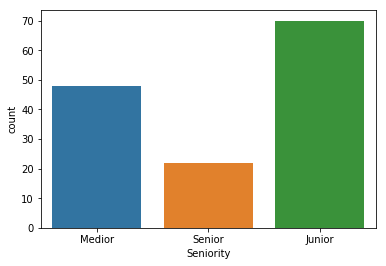

In [263]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=df['Seniority'])

In [264]:
X.shape

(140, 647)

In [266]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

scores = cross_val_score(MultinomialNB(), X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(MultinomialNB(), X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.6407 (+/- 0.1064)
F1: 0.6135 (+/- 0.0966)


In [283]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

clf = MultinomialNB()
clf.fit(Xtr, ytr)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [284]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.89      0.57      0.70        14
      Medior       0.60      0.90      0.72        10
      Senior       0.75      0.75      0.75         4

   micro avg       0.71      0.71      0.71        28
   macro avg       0.75      0.74      0.72        28
weighted avg       0.77      0.71      0.71        28



In [285]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype=object)

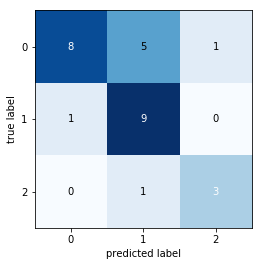

In [286]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [290]:
import numpy as np

feature_names = vect.get_feature_names()
for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: technik, erstellung, von vorteil, erfolgreich, einer, rollout, umgang, umgang mit, vorteil, ist, bei der, dem, au, einem, support, mitarbeit, dein, sachbearbeit, auf, erst

Medior: wunschenswert, deutsch, bietet, sicher, zum, profil erfolgreich, bearbeitung, umgang mit, sehr, erfolgreich abgeschlossen, sehr gute, al sachbearbeit, umgang, erfolgreich, window, administr, bei der, support, sachbearbeit, mitarbeit

Senior: account, finanz, gute englischkenntniss, posit handelt, buchhaltung, sehr, zum, sehr gute, auf, al bilanzbuchhalt, mehrjahrig, posit, nach hgb, mitarbeit, hgb, bei der, nach, control, erstellung, bilanzbuchhalt

